In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from util_data import *
from baseline_smc import *
from util_plots import *
from torch.distributions.dirichlet import Dirichlet
import sys
import datetime
import time 
sys.path.append('/home/hao/Research/probtorch/')
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 0.5.0a0+3bb8c5e cuda: True


In [2]:
## Dataset parameters
num_series = 1
## range of length of tracjectories, need to be positive integers
T_min = 50
T_max = 60
K = 4
D = 2
dt = 6
Boundary = 30
noise_ratio = 10.0

## Model Parameters
num_particles = 50
num_particles_smc = 30
NUM_HIDDEN = 32
NUM_LATENTS = K*K
NUM_OBS = 2 * D

NUM_EPOCHS = 400
LEARNING_RATE = 1e-3
CUDA = False
RESTORE = False
PATH_ENC = "baseline/1shot_enc-%dIS-enc-%s" % (num_particles, datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))

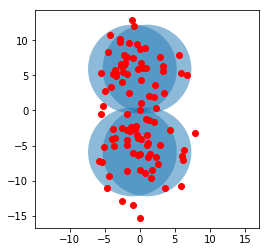

In [3]:
T_sample = 100
noise_cov = np.array([[1, 0], [0, 1]]) * noise_ratio       
init_v = np.random.random(2) * np.random.choice([-1,1], size=2)
v_norm = ((init_v ** 2 ).sum()) ** 0.5 ## compute norm for each initial velocity
init_v = init_v / v_norm * dt ## to make the velocity lying on a circle
mu_ks, cov_ks, Pi, Y, A_true, Zs_true = generate_seq_T(T_sample, K, dt, Boundary, init_v, noise_cov)
## true global variables
cov_true = np.tile(noise_cov, (K, 1, 1))
dirs = np.array([[1, 1], [1, -1], [-1, -1], [-1, 1]])
mu_true = np.tile(np.absolute(init_v), (K, 1)) * dirs
plot_clusters(Y.data.numpy(), mu_ks.data.numpy(), cov_ks.data.numpy(), K)

In [4]:
class Encoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.Tanh())
        self.latent_dir = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs):
        A_samples = torch.zeros((K, K))
        hidden = self.enc_hidden(obs)
        latents_dirs = F.softmax(self.latent_dir(hidden), -1).sum(0).view(K, K)
        for k in range(K):
            A_samples[k] = Dirichlet(latents_dirs[k]).sample()
        return latents_dirs, A_samples

In [5]:
def initialize():
    enc = Encoder()
    if CUDA:
        enc.cuda()
    optimizer =  torch.optim.Adam(list(enc.parameters()),lr=LEARNING_RATE)    
    return enc, optimizer
enc, optimizer = initialize()

In [6]:
KLs = []
EUBOs = []
ESSs = []
ELBOs = []
for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    optimizer.zero_grad()
    alpha_trans_0 = initial_trans_prior(K)
    init_v = init_velocity(dt)
    T = np.random.randint(T_min, T_max)
    mu_ks, cov_ks, Pi, Y, A_true, Z_true = generate_seq_T(T, K, dt, Boundary, init_v, noise_cov)
    enc, eubo, kl, ess, latents_dirs, elbo = oneshot_sampling(enc, alpha_trans_0, Pi, mu_ks, cov_ks, Z_true, Y, T, D, K, num_particles, num_particles_smc)
    eubo.backward()
    KLs.append(kl.item())
    EUBOs.append(eubo.item())
    ESSs.append(ess / num_particles)
    ELBOs.append(elbo.item())
#     log_qs.append(loss_infer.item())
    optimizer.step()
    time_end = time.time()
    print('epoch : %d, eubo : %f, elbo : %f,  KL : %f (%ds)' % (epoch, eubo, elbo, kl, time_end - time_start))

if RESTORE:
    enc.load_state_dict(torch.load(PATH_ENC))
else:
    torch.save(enc.state_dict(), PATH_ENC)
    save_params(KLs, EUBOs, ESSs, PATH_ENC)

epoch : 0, eubo : -334.304382, elbo : -344.354523,  KL : 14.782564 (4s)
epoch : 1, eubo : -326.908539, elbo : -339.996246,  KL : 13.986224 (4s)
epoch : 2, eubo : -342.303009, elbo : -358.309601,  KL : 13.938396 (4s)
epoch : 3, eubo : -334.102966, elbo : -344.292267,  KL : 15.105906 (4s)
epoch : 4, eubo : -339.088562, elbo : -346.776062,  KL : 13.601841 (4s)
epoch : 5, eubo : -330.618805, elbo : -341.141541,  KL : 16.033827 (4s)
epoch : 6, eubo : -317.266479, elbo : -331.771759,  KL : 15.121728 (4s)
epoch : 7, eubo : -317.236145, elbo : -325.874908,  KL : 13.745158 (4s)
epoch : 8, eubo : -331.243042, elbo : -341.547272,  KL : 11.749863 (4s)
epoch : 9, eubo : -309.808289, elbo : -319.700989,  KL : 15.198503 (4s)
epoch : 10, eubo : -288.904541, elbo : -298.930664,  KL : 15.005093 (3s)
epoch : 11, eubo : -316.300537, elbo : -330.273376,  KL : 15.182055 (4s)
epoch : 12, eubo : -299.825256, elbo : -313.344666,  KL : 12.671234 (4s)
epoch : 13, eubo : -301.943573, elbo : -313.462433,  KL : 12.

KeyboardInterrupt: 

In [ ]:
plot_dirs(latents_dirs, alpha_trans_0, Z_true, T, K, vmax=15)

In [ ]:
plot_results(EUBOs, ELBOs, log_qs, KLs, ESSs)

In [ ]:
# a = 
# for i in range(10):
#     a = log_weights[:, -1] - logsumexp(log_weights[:, -1], dim=0)
#     print(Categorical(a).sample().item())
# b = torch.FloatTensor([-3,-2,-1,-4])
# for i in range(10):
#     print(Categorical(b).sample())
#     c = torch.exp(b - logsumexp(b, dim=0))
#     print(Categorical(c).sample())
#     print('===============')